In [2]:
import sys
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split

# CONFIG

In [3]:
#
# Load config from 'config.txt'
#
def load_config():
    with open("config.txt", "r") as f:
        configtxt = f.readlines()
    configtxt = "".join(configtxt)
    return yaml.load(configtxt, Loader=yaml.FullLoader)        

def save_config(data):
    with open("config.txt", "w") as f:
        yaml.dump(data, f)

# LAG

In [756]:
def lag_time_series(serie, Pmax, remove_lag_zero=True):
    df = pd.DataFrame(serie)
    for p in range(1, Pmax + 1):
        df["P_{:d}".format(p)] = serie.shift(periods=p, fill_value=0)
    if remove_lag_zero:
        df.pop(df.columns[0])
    return df

# ONI

In [ ]:
class ONI_analyzer:
    def __init__(self):
        self.ONI = pd.read_csv("data/data.csv").ONI[0:240]
    
    def run(self, Pmax):
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p)
            y = self.ONI
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['ONI']['P_OPT'] = Popt
        save_config(data)

ONI_analyzer().run(Pmax=10)


In [757]:
class ONI_simulator:
    def __init__(self):
        self.ONI = pd.read_csv("data/data.csv").ONI[0:240]
        data = load_config()
        self.P = data["ONI"]["P_OPT"]
        
    def fit(self):
        #
        # Entrena el modelo usando todos los datos historicos disponibles
        #
        x = lag_time_series(serie=self.ONI, Pmax=self.P)
        y = self.ONI
        self.m = linear_model.LinearRegression()
        self.m.fit(x, y)
        self.errors = (self.ONI - self.m.predict(x))[self.P + 1 :]
        self.errors = self.errors.tolist()

    def get_syntetic_series(self, t_base):
        y = self.ONI.copy()
        for t in range(t_base, 264):
            y[t] = self.m.intercept_
            for p in range(1, self.P + 1):
                y[t] += y[t - p] * self.m.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        return y
        
    def run(self):

        self.fit()
        
        CONFIG = load_config()

        for t_base in range(204, 241):

            #
            # Genera las simulaciones
            #
            simulations = {}
            for i_sim in range(CONFIG["ONI"]["NUMSIM"]):
                simulations[i_sim] = self.get_syntetic_series(t_base)

            #
            # Computa la media
            #
            means = []
            for i_sim in range(CONFIG["ONI"]["NUMSIM"]):
                means.append((i_sim, simulations[i_sim][t_base : t_base + 24].mean()))

            #
            # ordena por las medias
            #
            means = sorted(means, key=itemgetter(1))

            #
            # Percentiles
            #
            escenarios = CONFIG["ONI"]["ESCENARIOS"].copy()
            escenarios = [int(len(means) * float(e) / 100) for e in escenarios]
            escenarios = [means[e][0] for e in escenarios]

            for e, p in zip(escenarios, CONFIG["ONI"]["ESCENARIOS"].copy()):
                filename = str(t_base) + "/" + "ONI_" + str(p) + ".csv"
                simulations[e].to_csv(filename, index=False)

#ModeloONI().run()
ONI_simulator().run()

## Aportes

In [ ]:
class APORTES_analyzer:
    def __init__(self):
        
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
    
    
    def compute_P_OPT_ONI(self, Pmax):
        #
        # Computa el orden optimo para remover el efecto del ONI
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P   MSE_train    MSE_test P_opt")
        print("---------------------------------")

        
        for p in range(0, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p, remove_lag_zero=False)
            x = pd.concat([x, self.dummies], axis=1)
            y = self.Aportes
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}  {:10.2f}  {:10.2f}    {:2d}".format(p, mse_train, mse_test, Popt))

        data = load_config()
        data['APORTES']['P_ONI_OPT'] = Popt
        save_config(data)

    def compute_P_OPT_APORTES(self, Pmax):

        #
        # Remueve el efecto de los aportes
        #
        P_ONI = load_config()['APORTES']['P_ONI_OPT']
        
        x = lag_time_series(serie=self.ONI, Pmax=P_ONI, remove_lag_zero=False)
        x = pd.concat([x, self.dummies], axis=1)
        m = linear_model.LinearRegression()
        m.fit(x, self.Aportes)
        aportes_sin_oni  = m.predict(x)
        
        #
        # Remueve el ciclo estacional
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(aportes_sin_oni)], axis=1
        )
        x.columns = [x.columns[0], "aportes_sin_oni"]
        means_stds = x.groupby("Mes").agg({"aportes_sin_oni": [np.mean, np.std]})
        means_stds.columns = ["mean_mes", "std_mes"]
        aportes_sin_oni_z = [
            (v - means_stds["mean_mes"][t]) / means_stds["std_mes"][t]
            for v, t in zip(aportes_sin_oni, self.Mes)
        ]
        aportes_sin_oni_z = pd.Series(aportes_sin_oni_z)
        
        #
        # Computa el orden optimo del modelo
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P   MSE_train    MSE_test P_opt")
        print("---------------------------------")
        
        for p in range(1, Pmax + 1):
            
            #
            # Regresores
            #
            x = lag_time_series(
                serie=aportes_sin_oni_z, Pmax=p, remove_lag_zero=True
            )
            y = aportes_sin_oni_z

            #
            # Muestra de entrenamiento
            #
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            #
            # Ajuste y reporte de errores
            #
            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
                        
            print("{:2d}  {:10.8f}  {:10.8f}    {:2d}".format(p, mse_train, mse_test, Popt))

        data = load_config()
        data['APORTES']['P_APORTES_OPT'] = Popt
        save_config(data)



APORTES_analyzer().compute_P_OPT_ONI(Pmax=24)
APORTES_analyzer().compute_P_OPT_APORTES(Pmax=24)

In [758]:
class APORTES_simulator:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
        data = load_config()
        self.P_ONI = data['APORTES']['P_ONI_OPT']
        self.P_Aportes = data['APORTES']['P_APORTES_OPT']

        
    def step_1_remove_ONI(self):
        #
        # Remueve el efecto del ONI de todos los datos
        #
        x = lag_time_series(serie=self.ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        x = pd.concat([x, self.dummies], axis=1)
        y = self.Aportes
        self.modelo_oni = linear_model.LinearRegression()
        self.modelo_oni.fit(x, y)
        self.aportes_sin_oni = self.Aportes - self.modelo_oni.predict(x)

        
    def step_2_remove_seasonal_cycle(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.aportes_sin_oni)], axis=1
        )
        x.columns = [x.columns[0], "aportes_sin_oni"]
        self.means_stds = x.groupby("Mes").agg({"aportes_sin_oni": [np.mean, np.std]})
        self.means_stds.columns = ["mean_mes", "std_mes"]
        self.aportes_sin_oni_z = [
            (v - self.means_stds["mean_mes"][t]) / self.means_stds["std_mes"][t]
            for v, t in zip(self.aportes_sin_oni, self.Mes)
        ]
        self.aportes_sin_oni_z = pd.Series(self.aportes_sin_oni_z)
        
        
    def step_3_fit(self):
        #
        x = lag_time_series(serie=self.aportes_sin_oni_z, Pmax=self.P_Aportes)
        self.modelo_Aportes = linear_model.LinearRegression()
        self.modelo_Aportes.fit(x, self.aportes_sin_oni_z)
        self.errors = (self.aportes_sin_oni_z - self.modelo_Aportes.predict(x))[self.P_Aportes + 1 :]
        self.errors = self.errors.tolist()


    def step_4_generate_syntetic_aportes_sin_oni_z(self, t_base):
        #
        y = self.aportes_sin_oni_z.copy()

        for t in range(t_base, 264):
            y[t] = self.modelo_Aportes.intercept_
            for p in range(1, self.P_Aportes + 1):
                y[t] += y[t - p] * self.modelo_Aportes.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        self.sintetic_aportes_sin_oni_z = y.copy()

    def step_5_generate_syntetic_aportes_sin_oni(self):

        x = pd.DataFrame({"z": self.sintetic_aportes_sin_oni_z})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        x["Mean"] = x.Mes.map(lambda w: self.means_stds.mean_mes[w])
        x["Std"] = x.Mes.map(lambda w: self.means_stds.std_mes[w])
        x["sintetic_aportes_sin_oni"] = self.sintetic_aportes_sin_oni_z * x.Std + x.Mean
        self.sintetic_aportes_sin_oni = x.sintetic_aportes_sin_oni
        
        
    def step_6_generate_syntetic_Aportes(self, sintetica_ONI, t_base):

        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        

        x = lag_time_series(serie=sintetica_ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        
        x = pd.concat([x, dummies], axis=1)
        
        self.sintetic_Aportes = (
            self.sintetic_aportes_sin_oni + self.modelo_oni.predict(x)
        )
        

        
    def run(self):
        
        CONFIG = load_config()

        self.step_1_remove_ONI()
        self.step_2_remove_seasonal_cycle()
        self.step_3_fit()
    
        for t_base in range(204, 241):

            self.step_4_generate_syntetic_aportes_sin_oni_z(t_base)
            self.step_5_generate_syntetic_aportes_sin_oni()

            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
            
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
            
                    filename = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename)['ONI']
                    self.step_6_generate_syntetic_Aportes(sintetica_ONI, t_base)
                    self.sintetic_Aportes.to_csv("{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario), index=False)

APORTES_simulator().run()

## GHIDRO

In [ ]:
class GHIDRO_analyzer:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]


    def compute_p_optimal_explanatory(self, P_max_aportes, P_max_oni):

        P_opt_oni = None
        P_opt_aportes = None
        mse_test_opt = None
        print()
        print(" P_aportes P_oni  MSE_train    MSE_test P_opt_aportes  P_opt_oni")
        print("------------------------------------------------------------------------------------")

        for p_aportes in range(0, P_max_aportes + 1):
            for p_oni in range(0, P_max_oni + 1):

                #
                # Regresores
                #
                x_oni = lag_time_series(
                    serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
                )
                x_aportes = lag_time_series(
                    serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
                )

                x = pd.concat([x_oni, x_aportes,  self.dummies], axis=1)
                y = self.ghidro

                #
                # Muestra de entrenamiento
                #
                (
                    x_train,
                    x_test,
                    y_train_real,
                    y_test_real,
                ) = train_test_split(x, y, test_size=0.4, random_state=0)

                #
                # Ajuste y reporte de errores
                #
                m = linear_model.LinearRegression()
                m.fit(x_train, y_train_real)

                y_train_predict = m.predict(x_train)
                y_test_predict = m.predict(x_test)
                mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
                mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)

                if mse_test_opt is None or mse_test < mse_test_opt:
                    P_opt_aportes = p_aportes
                    P_opt_oni = p_oni
                    mse_test_opt = mse_test

                print(
                    "        {:2d}  {:2d}   {:10.2f}  {:10.2f}            {:2d}        {:2d}".format(
                        p_aportes, p_oni, mse_train, mse_test, P_opt_aportes, P_opt_oni
                    )
                )

            data = load_config()
            if "GHIDRO" not in data.keys():
                data["GHIDRO"] = {}
            data["GHIDRO"]["P_APORTES_OPT"] = P_opt_aportes
            data["GHIDRO"]["P_ONI_OPT"] = P_opt_oni
            save_config(data)


        
    def compute_p_optimal(self, Pmax):
        
        data = load_config()
        p_aportes = data["GHIDRO"]["P_APORTES_OPT"]
        p_oni = data["GHIDRO"]["P_ONI_OPT"]
        
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )
        x = pd.concat([x_oni, x_aportes,  self.dummies], axis=1)
        y = self.ghidro

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)
        
        #
        # Aportes sin variables explicativas
        #
        ghidro = y - predict

        #
        # Componente autorregresiva
        # Esta parte es identica al modelo del ONI
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(ghidro.copy(), Pmax=p, remove_lag_zero=True)
            y = ghidro.copy()
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['GHIDRO']['P_OPT'] = Popt
        save_config(data)    
    
x=GHIDRO_analyzer()
x.compute_p_optimal_explanatory(P_max_aportes=15, P_max_oni=10)
x.compute_p_optimal(Pmax = 15)
#GHIDRO_analyzer().compute_p_optimal(Pmax=15)

In [759]:
class GHIDRO_simulator:

    
    def run(self):
        
        data = load_config()
        p_aportes = data["GHIDRO"]["P_APORTES_OPT"]
        p_oni = data["GHIDRO"]["P_ONI_OPT"]
        
        
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]  
        
        #
        # Remueve el efecto de las variables explicativas
        #
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )

        x = pd.concat([x_oni, x_aportes, self.dummies], axis=1)
        y = self.ghidro

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m_regressors = linear_model.LinearRegression()
        m_regressors.fit(x, y)
        m_regressors_predict = m_regressors.predict(x)
        ghidro = y - m_regressors_predict

        
        # Modelo autorregresivo de la generación hidraúlica 
        # sin efectos de variables explicativas
        #
        p_opt = data['GHIDRO']['P_OPT']
        w = lag_time_series(ghidro.copy(), Pmax=p_opt, remove_lag_zero = True)
        y = ghidro.copy()
        m_ghidro = linear_model.LinearRegression()
        m_ghidro.fit(w, y)
        errors = y - m_ghidro.predict(w)
        errors = errors[p_opt:].tolist()
        
        CONFIG = load_config()
        
        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        
        for t_base in range(204, 241):

            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
                
                
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
                    
                    #
                    # Componentes autoregresiva 
                    #
                    z = ghidro.copy()
                    
                    for t in range(t_base, 264):
                        z[t] = m_ghidro.intercept_
                        for p in range(1, p_opt + 1):
                            z[t] += z[t - p] * m_ghidro.coef_[p - 1]
                        z[t] += errors[np.random.randint(0, len(errors))]
                
                    
                    #
                    # Efecto de variables explicativas
                    #
                    filename_oni = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename_oni)['ONI']
                    
                    filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_aportes = pd.read_csv(filename_aportes)['sintetic_aportes_sin_oni']

                    w_oni = lag_time_series(
                        serie=sintetica_ONI, Pmax=p_oni, remove_lag_zero=False
                    )
                    w_aportes = lag_time_series(
                        serie=sintetica_aportes, Pmax=p_aportes, remove_lag_zero=False
                    )

                    w = pd.concat([w_oni, w_aportes, dummies], axis=1)
                    
                    z = z + m_regressors.predict(w)

                    
                    filename = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    z.to_csv(filename, index=False)
    
GHIDRO_simulator().run()

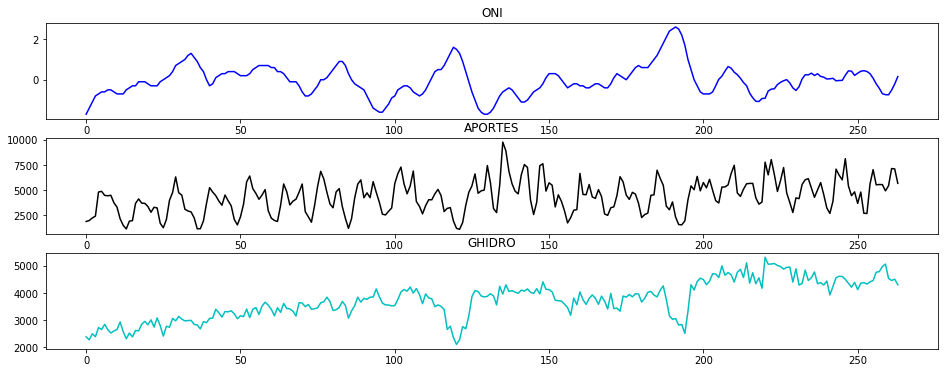

In [760]:
prueba_oni = pd.read_csv("205/ONI_11.csv")
prueba_aportes = pd.read_csv("205/APORTES_0002_ONI_11.csv")
prueba_ghidro = pd.read_csv("205/GHIDRO_0002_ONI_11.csv")

plt.figure(figsize=(16,6))
plt.subplot(311)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(312)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(313)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.show()

## EMBALSE

In [ ]:
class EMBALSE_analyzer:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.aportes = x.Aportes_GWh[0:240]
        self.embalse = x.Volumen_Util_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
    def normalizar_embalse(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.embalse)], axis=1
        )
        x.columns = [x.columns[0], "embalse"]
        self.means_stds_embalse = x.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t]) / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.embalse, self.Mes)
        ]
        self.embalse_z = pd.Series(self.embalse_z)

    def compute_p_optimal_explanatory(self, P_max_aportes, P_max_oni, P_max_ghidro):

        P_opt_oni = None
        P_opt_aportes = None
        P_opt_ghidro = None
        mse_test_opt = None
        print()
        print(" P_aportes P_oni P_ghidro MSE_train    MSE_test P_opt_aportes  P_opt_oni P_opt_ghidro")
        print("------------------------------------------------------------------------------------")

        for p_aportes in range(0, P_max_aportes + 1):
            for p_oni in range(0, P_max_oni + 1):
                for p_ghidro in range(0, P_max_ghidro + 1):
                
                    #
                    # Regresores
                    #
                    x_oni = lag_time_series(
                        serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
                    )
                    x_aportes = lag_time_series(
                        serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
                    )
                    x_ghidro = lag_time_series(
                        serie=self.ghidro, Pmax=p_ghidro, remove_lag_zero=False
                    )
                    x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
                    y = self.embalse_z

                    #
                    # Muestra de entrenamiento
                    #
                    (
                        x_train,
                        x_test,
                        y_train_real,
                        y_test_real,
                    ) = train_test_split(x, y, test_size=0.4, random_state=0)

                    #
                    # Ajuste y reporte de errores
                    #
                    m = linear_model.LinearRegression()
                    m.fit(x_train, y_train_real)

                    y_train_predict = m.predict(x_train)
                    y_test_predict = m.predict(x_test)
                    mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
                    mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)

                    if mse_test_opt is None or mse_test < mse_test_opt:
                        P_opt_aportes = p_aportes
                        P_opt_oni = p_oni
                        P_opt_ghidro = p_ghidro
                        mse_test_opt = mse_test

                    print(
                        "        {:2d}  {:2d}  {:2d}  {:10.2f}  {:10.2f}            {:2d}   {:2d}   {:2d}".format(
                            p_aportes, p_oni, p_ghidro, mse_train, mse_test, P_opt_aportes, P_opt_oni, P_opt_ghidro
                        )
                    )

            data = load_config()
            if "EMBALSE" not in data.keys():
                data["EMBALSE"] = {}
            data["EMBALSE"]["P_APORTES_OPT"] = P_opt_aportes
            data["EMBALSE"]["P_ONI_OPT"] = P_opt_oni
            data["EMBALSE"]["P_GHIDRO_OPT"] = P_opt_ghidro
            save_config(data)


        
    def compute_p_optimal(self, Pmax):
        
        data = load_config()
        p_aportes = data["EMBALSE"]["P_APORTES_OPT"]
        p_oni = data["EMBALSE"]["P_ONI_OPT"]
        p_ghidro = data["EMBALSE"]["P_GHIDRO_OPT"]
        
        
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.aportes, Pmax=p_aportes, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=self.ghidro, Pmax=p_ghidro, remove_lag_zero=False
        )
        x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
        y = self.embalse_z

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)
        
        #
        # Embalse sin variables explicativas
        #
        embalse = y - predict

        #
        # Componente autorregresiva
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(embalse.copy(), Pmax=p, remove_lag_zero=True)
            y = embalse.copy()
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test
            
            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))
            
        data = load_config()
        data['EMBALSE']['P_OPT'] = Popt
        save_config(data)    
    
x=EMBALSE_analyzer()
x.normalizar_embalse()
x.compute_p_optimal_explanatory(P_max_aportes=15, P_max_oni=10, P_max_ghidro = 15 )
x.compute_p_optimal(Pmax = 15)
#GHIDRO_analyzer().compute_p_optimal(Pmax=15)

In [761]:
class EMBALSE_simulator:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.embalse = x.Volumen_Util_GWh[0:240]
        self.ghidro = x.Generacion_Hidro_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]
        
        data = load_config()
        self.P_ONI = data['EMBALSE']['P_ONI_OPT']
        self.P_Aportes = data['EMBALSE']['P_APORTES_OPT']
        self.P_Ghidro = data['EMBALSE']['P_GHIDRO_OPT']
        self.P_Embalse = data['EMBALSE']['P_OPT']
        
    def normalizar_embalse(self):
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.embalse)], axis=1
        )
        x.columns = [x.columns[0], "embalse"]
        self.means_stds_embalse = x.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t]) / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.embalse, self.Mes)
        ]
        self.embalse_z = pd.Series(self.embalse_z)

        
    def step_1_remove_ONI_Aportes(self):
        #
        # Remueve el efecto del ONI y aportes de todos los datos
        #
        # Regresores
                
        x_oni = lag_time_series(
            serie=self.ONI, Pmax=self.P_ONI, remove_lag_zero=False
        )
        x_aportes = lag_time_series(
            serie=self.Aportes, Pmax=self.P_Aportes, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=self.ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False
        )

        x = pd.concat([x_oni, x_aportes, x_ghidro, self.dummies], axis=1)
        
        y = self.embalse_z

        self.modelo_explicativas = linear_model.LinearRegression()
        self.modelo_explicativas.fit(x, y)
        self.embalse_z_sin_explicativas = self.embalse_z - self.modelo_explicativas.predict(x)
        
    def step_2_fit(self):
        #
        x = lag_time_series(serie=self.embalse_z_sin_explicativas, Pmax=self.P_Embalse, remove_lag_zero = True)
        self.modelo_Embalse = linear_model.LinearRegression()
        self.modelo_Embalse.fit(x, self.embalse_z_sin_explicativas)
        self.errors = (self.embalse_z_sin_explicativas - self.modelo_Embalse.predict(x))[self.P_Embalse + 1 :]
        self.errors = self.errors.tolist()


    def step_3_generate_syntetic_embalse_z_sin_explicativas(self, t_base):
        #
        y = self.embalse_z_sin_explicativas.copy()

        for t in range(t_base, 264):
            y[t] = self.modelo_Embalse.intercept_
            for p in range(1, self.P_Embalse + 1):
                y[t] += y[t - p] * self.modelo_Embalse.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        self.syntetic_embalse_z_sin_explicativas = y.copy()
    
    def step_4_generate_syntetic_embalse_z(self, sintetica_ONI, sintetica_Aportes, sintetica_ghidro, t_base):

        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 264)
        )
        dummies = pd.concat([self.dummies, dummies], axis=0)
        

        x_oni = lag_time_series(serie=sintetica_ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        x_aportes = lag_time_series(serie=sintetica_Aportes, Pmax=self.P_Aportes, remove_lag_zero=False)
        x_ghidro = lag_time_series(serie=sintetica_ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False)
        x = pd.concat([x_oni, x_aportes, x_ghidro, dummies], axis=1)
        
        self.syntetic_embalse_z = (
            self.syntetic_embalse_z_sin_explicativas + self.modelo_explicativas.predict(x)
        )

    def step_5_generate_syntetic_embalse(self):

        x = pd.DataFrame({"z": self.syntetic_embalse_z})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        x["Mean"] = x.Mes.map(lambda w: self.means_stds_embalse.mean_mes[w])
        x["Std"] = x.Mes.map(lambda w: self.means_stds_embalse.std_mes[w])
        x["syntetic_embalse"] = self.syntetic_embalse_z * x.Std + x.Mean
        self.syntetic_embalse = x.syntetic_embalse
        
    def run(self):
        
        CONFIG = load_config()

        self.step_1_remove_ONI_Aportes()
        self.step_2_fit()
    
        for t_base in range(204, 241):

         
            for escenario in CONFIG["ONI"]["ESCENARIOS"]:
            
                for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):
             
                    filename_oni = str(t_base) + "/" + "ONI_" + str(escenario) + ".csv"
                    sintetica_ONI = pd.read_csv(filename_oni)['ONI']
                    filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_aportes = pd.read_csv(filename_aportes)['sintetic_aportes_sin_oni']
                    filename_ghidro = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario)
                    sintetica_ghidro = pd.read_csv(filename_ghidro)['Generacion_Hidro_GWh']
                    self.step_3_generate_syntetic_embalse_z_sin_explicativas(t_base)
                    self.step_4_generate_syntetic_embalse_z(sintetica_ONI, sintetica_aportes, sintetica_ghidro, t_base)
                    self.step_5_generate_syntetic_embalse()
                    self.syntetic_embalse.to_csv("{}/EMBALSE_{:04d}_ONI_{}.csv".format(t_base, i_serie, escenario), index=False)
                    
x = EMBALSE_simulator()
x.normalizar_embalse()
x.run()

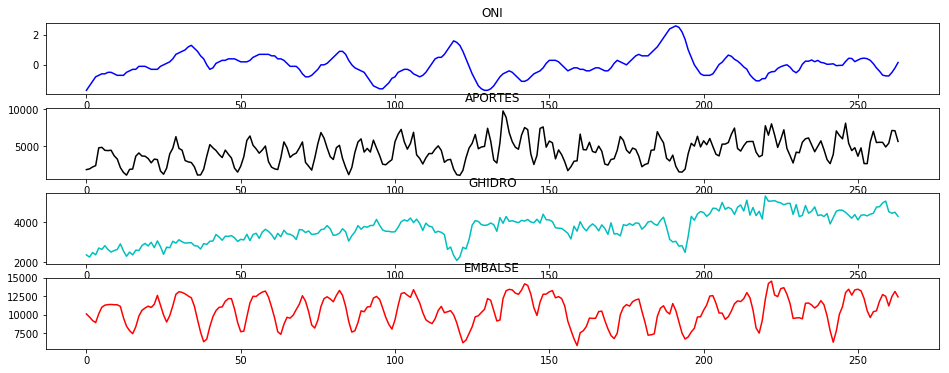

In [762]:
prueba_oni = pd.read_csv("205/ONI_11.csv")
prueba_aportes = pd.read_csv("205/APORTES_0002_ONI_11.csv")
prueba_ghidro = pd.read_csv("205/GHIDRO_0002_ONI_11.csv")
prueba_embalse = pd.read_csv("205/EMBALSE_0002_ONI_11.csv")

plt.figure(figsize=(16,6))
plt.subplot(411)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(412)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(413)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.subplot(414)
plt.title("EMBALSE")
plt.plot(prueba_embalse, 'r')
plt.show()

## Escenarios demanda

In [675]:
def generar_escenarios_demanda():
    
    def generar_escenario_1(t_base, f0):

        mes_actual = data.Mes[t_base]
        ano_actual = data.Ano[t_base]
        dem_mes_real = data.Demanda_GWh[data.Ano == ano_actual]

        dem_mes_real = dem_mes_real[0:mes_actual - 1].tolist()
        dem_mes_anterior = data.Demanda_GWh[t_base - 1]
        tasa_diaria = (1 + f0 / 100) ** (1 / 365) - 1
        dem_mes_actual = dem_mes_anterior * (1 + tasa_diaria) ** data.dias_mes[t_base]
        dem_mes_real.append(dem_mes_actual)
        for i in range(mes_actual -1 , 11):

            dem_mes = dem_mes_real[i] * (1 + tasa_diaria) ** data.dias_mes[t_base + 1]
            dem_mes_real.append(dem_mes)

        return dem_mes_real

    def generar_escenario(t_base, factores):

        FMESES = [
            0.08158999,
            0.07753591,
            0.08409445,
            0.08116052,
            0.08459621,
            0.08150497,
            0.08469948,
            0.08583286,
            0.08392501,
            0.08573493,
            0.08348462,
            0.08584105,
        ]
        FECHAS = [
        "{:d}-{:02d}".format(ano, mes + 1) for ano in range(2000, 2023) for mes in range(12)
        ]
        
        df = pd.DataFrame({"fecha": FECHAS})
        data = pd.read_csv("data/data.csv")
        num_escenarios = int(len(factores) / 3)
        for i_escenario in range(num_escenarios):

            f0 = factores[i_escenario * 3]
            f1 = factores[i_escenario * 3 + 1]
            f2 = factores[i_escenario * 3 + 2]
            ts = data.Demanda_GWh.copy()
            
            ano_actual = data.Ano[t_base]
            ano_anterior = ano_actual - 1
            dem_anual_anterior = sum(data.Demanda_GWh[data.Ano == ano_anterior])
            dem_anual_actual = dem_anual_anterior * (1 + f0 / 100)
            mes_actual = data.Mes[t_base]
                
            if(mes_actual == 1):
                dem_mes_pry = [dem_anual_actual * f for f in FMESES]
                
            else:
                dem_mes_pry = generar_escenario_1(t_base, f0)
                

            suma_dem_mes_pry = sum(dem_mes_pry)
            
            dem_anual_sig_1 = suma_dem_mes_pry * (1 + f1 / 100)
            dem_anual_sig_2 = dem_anual_sig_1 * (1 + f2 / 100)
            dem_anual_sig_3 = dem_anual_sig_2 * (1 + f2 / 100)
            dem_anual_sig_4 = dem_anual_sig_3 * (1 + f2 / 100)
            dem_anual_sig_5 = dem_anual_sig_4 * (1 + f2 / 100)

            dem_mes_sig_1 = [dem_anual_sig_1 * x for x in FMESES]
            dem_mes_sig_2 = [dem_anual_sig_2 * x for x in FMESES]
            dem_mes_sig_3 = [dem_anual_sig_3 * x for x in FMESES]
            dem_mes_sig_4 = [dem_anual_sig_4 * x for x in FMESES]
            dem_mes_sig_5 = [dem_anual_sig_5 * x for x in FMESES]

            dem_mes = dem_mes_pry + dem_mes_sig_1 + dem_mes_sig_2 +  dem_mes_sig_3 + dem_mes_sig_4 + dem_mes_sig_5
            
            L = len(list(range(t_base, 265)))
            
            dem_mes = dem_mes[mes_actual - 1 : (mes_actual -1) + L - 1]
            ts[t_base : 264] = dem_mes

            df["esc-{:d}".format(i_escenario)] = ts


        return df

    data = pd.read_csv("data/data.csv")
    data = data.assign(dias_mes=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * 22)

    #data_escenarios = pd.read_csv("data/esc-dem-agente.csv")
    data_escenarios = pd.read_csv("data/1esc-dem-agente.csv",sep = ";", decimal = ".")
    for t_base in range(204, 241):
        num_escenarios = int((len(data_escenarios.columns) - 1) / 3) - 1
        cols_escenarios = [
            1 + i * 3 + j for i in range(num_escenarios) for j in range(3)
        ]
        factores = data_escenarios.loc[t_base, data_escenarios.columns[cols_escenarios]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-agente.csv", index=False
        )

    '''data_escenarios = pd.read_csv("data/esc-dem-operador.csv")
    for t_base in range(204, 241):
        factores = data_escenarios.loc[t_base, data_escenarios.columns[[1, 2, 3]]]
        filename =  str(t_base)
        generar_escenario(t_base, factores).to_csv(
            filename + "/series-esc-dem-operador.csv", index=False
        )'''


generar_escenarios_demanda()

In [676]:
data_escenarios = pd.read_csv("data/1esc-dem-agente.csv",sep = ";", decimal = ".")
#data_escenarios[220:250]

## MODELO PRECIOS

In [ ]:
class PRECIO_analyzer:
    def __init__(self):

        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.Embalse = x.Volumen_Util_GWh[0:240]
        self.Ghidro = x.Generacion_Hidro_GWh[0:240]
        self.Demanda = x.Demanda_GWh[0:240]
        self.Termica = x.Demanda_GWh[0:240] - x.Generacion_Hidro_GWh[0:240]

    def normalizar_aportes(self):
        #
        ## Remueve el ciclo estacional de los aportes
        #
        x = pd.concat([pd.DataFrame(self.Mes), pd.DataFrame(self.Aportes)], axis=1)
        x.columns = [x.columns[0], "aportes"]
        self.means_stds_aportes = x.groupby("Mes").agg({"aportes": [np.mean, np.std]})
        self.means_stds_aportes.columns = ["mean_mes", "std_mes"]
        self.Aportes_z = [
            (v - self.means_stds_aportes["mean_mes"][t])
            / self.means_stds_aportes["std_mes"][t]
            for v, t in zip(self.Aportes, self.Mes)
        ]
        self.Aportes_z = pd.Series(self.Aportes_z)
        

    def normalizar_embalse(self):
        #
        ## Remueve el ciclo estacional del embalse
        #
        x = pd.concat([pd.DataFrame(self.Mes), pd.DataFrame(self.Embalse)], axis=1)
        x.columns = [x.columns[0], "embalse"]
        self.means_stds_embalse = x.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.Embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t])
            / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.Embalse, self.Mes)
        ]
        self.Embalse_z = pd.Series(self.Embalse_z)


    def precio_constantes(self):
        #
        ## Precios corrientes a constantes en la serie del precio de la energía
        #
        x = pd.read_csv("data/data.csv")
        x = x.assign(Factor_IPC=x.IPC / x.IPC[239])
        x = x.assign(Precio_Const=x.Precio_Bolsa * x.Factor_IPC)
        x = x.assign(Log_Precio=x.Precio_Const.map(np.log))
        self.Precio_log = x.Log_Precio[0:240]


    def compute_p_optimal_explanatory(
        self,
        P_max_oni,
        P_max_aportes,
        P_max_embalse,
        P_max_ghidro,
        P_max_demanda,
        P_max_termica,
    ):

        P_opt_oni = None
        P_opt_aportes = None
        P_opt_embalse = None
        P_opt_ghidro = None
        P_opt_demanda = None
        P_opt_termica = None
        mse_test_opt = None
        print()
        print(
            " P_oni P_aportes P_oni P_embasle P_ghidro P_demanda P_termica MSE_train MSE_test P_opt_oni P_opt_aportes P_opt_embalse P_opt_ghidro P_opt_demanda P_opt_termica"
        )
        print(
            "---------------------------------------------------------------------------------------------------------------------------------------------------------------"
        )

        for p_oni in range(0, P_max_oni + 1):
            for p_aportes in range(0, P_max_aportes + 1):
                for p_embalse in range(0, P_max_embalse + 1):
                    for p_ghidro in range(0, P_max_ghidro + 1):
                        for p_demanda in range(0, P_max_demanda + 1):
                            for p_termica in range(0, P_max_termica + 1):

                                #
                                # Regresores
                                #
                                x_oni = lag_time_series(
                                    serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
                                )
                                x_aportes_z = lag_time_series(
                                    serie=self.Aportes_z,
                                    Pmax=p_aportes,
                                    remove_lag_zero=False,
                                )
                                x_embalse_z = lag_time_series(
                                    serie=self.Embalse_z,
                                    Pmax=p_embalse,
                                    remove_lag_zero=False,
                                )
                                x_ghidro = lag_time_series(
                                    serie=self.Ghidro,
                                    Pmax=p_ghidro,
                                    remove_lag_zero=False,
                                )
                                x_demanda = lag_time_series(
                                    serie=self.Demanda,
                                    Pmax=p_demanda,
                                    remove_lag_zero=False,
                                )
                                x_termica = lag_time_series(
                                    serie=self.Termica,
                                    Pmax=p_termica,
                                    remove_lag_zero=False,
                                )
                                x = pd.concat(
                                    [
                                        x_oni,
                                        x_aportes_z,
                                        x_embalse_z,
                                        x_ghidro,
                                        x_demanda,
                                        x_termica,
                                    ],
                                    axis=1,
                                )
                                y = self.Precio_log

                                #
                                # Muestra de entrenamiento
                                #
                                (
                                    x_train,
                                    x_test,
                                    y_train_real,
                                    y_test_real,
                                ) = train_test_split(
                                    x, y, test_size=0.4, random_state=0
                                )

                                #
                                # Ajuste y reporte de errores
                                #
                                m = linear_model.LinearRegression()
                                m.fit(x_train, y_train_real)

                                y_train_predict = m.predict(x_train)
                                y_test_predict = m.predict(x_test)
                                mse_train = metrics.mean_squared_error(
                                    y_train_real, y_train_predict
                                )
                                mse_test = metrics.mean_squared_error(
                                    y_test_real, y_test_predict
                                )

                                if mse_test_opt is None or mse_test < mse_test_opt:
                                    P_opt_oni = p_oni
                                    P_opt_aportes = p_aportes
                                    P_opt_embalse = p_embalse
                                    P_opt_ghidro = p_ghidro
                                    P_opt_demanda = p_demanda
                                    P_opt_termica = p_termica
                                    mse_test_opt = mse_test

                                '''print(
                                    "{:2d} {:2d} {:2d} {:2d} {:2d} {:2d} {:10.2f} {:10.2f}        {:2d} {:2d} {:2d} {:2d} {:2d} {:2d}".format(
                                        p_oni,
                                        p_aportes,
                                        p_embalse,
                                        p_ghidro,
                                        p_demanda,
                                        p_termica,
                                        mse_train,
                                        mse_test,
                                        P_opt_oni,
                                        P_opt_aportes,
                                        P_opt_embalse,
                                        P_opt_ghidro,
                                        P_opt_demanda,
                                        P_opt_termica,
                                    )
                                )'''

                data = load_config()
                if "PRECIO" not in data.keys():
                    data["PRECIO"] = {}
                data["PRECIO"]["P_ONI_OPT"] = P_opt_oni
                data["PRECIO"]["P_APORTES_OPT"] = P_opt_aportes
                data["PRECIO"]["P_EMBALSE_OPT"] = P_opt_embalse
                data["PRECIO"]["P_GHIDRO_OPT"] = P_opt_ghidro
                data["PRECIO"]["P_DEMANDA_OPT"] = P_opt_demanda
                data["PRECIO"]["P_TERMICA_OPT"] = P_opt_termica
                save_config(data)

    def compute_p_optimal(self, Pmax):

        data = load_config()
        p_oni = data["PRECIO"]["P_ONI_OPT"]
        p_aportes = data["PRECIO"]["P_APORTES_OPT"]
        p_embalse = data["PRECIO"]["P_EMBALSE_OPT"]
        p_ghidro = data["PRECIO"]["P_GHIDRO_OPT"]
        p_demanda = data["PRECIO"]["P_DEMANDA_OPT"]
        p_termica = data["PRECIO"]["P_TERMICA_OPT"]        

        x_oni = lag_time_series(
            serie=self.ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes_z = lag_time_series(
            serie=self.Aportes_z, Pmax=p_aportes, remove_lag_zero=False
        )
        x_embalse_z = lag_time_series(
            serie=self.Embalse_z, Pmax=p_embalse, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=self.Ghidro, Pmax=p_ghidro, remove_lag_zero=False
        )
        x_demanda = lag_time_series(
            serie=self.Demanda, Pmax=p_demanda, remove_lag_zero=False
        ) 
        x_termica = lag_time_series(
            serie=self.Termica, Pmax=p_termica, remove_lag_zero=False
        )        
        x = pd.concat([x_oni, x_aportes_z, x_embalse_z, x_ghidro, x_demanda, x_termica], axis=1)
        y = self.Precio_log

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)

        #
        # Precio sin variables explicativas
        #
        precio = y - predict

        #
        # Componente autorregresiva
        #
        Popt = None
        mse_test_opt = None
        print()
        print(" P MSE_train MSE_test P_opt")
        print("----------------------------")
        for p in range(1, Pmax + 1):
            x = lag_time_series(precio.copy(), Pmax=p, remove_lag_zero=True)
            y = precio.copy()
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            if mse_test_opt is None or mse_test < mse_test_opt:
                Popt=p
                mse_test_opt = mse_test

            print("{:2d}    {:6.4f}   {:6.4f}    {:2d}".format(p, mse_train, mse_test, Popt))

        data = load_config()
        data['PRECIO']['P_OPT'] = Popt
        save_config(data)


x = PRECIO_analyzer()
x.normalizar_aportes()
x.normalizar_embalse()
x.precio_constantes()
x.compute_p_optimal_explanatory(P_max_oni=13, P_max_aportes=13, P_max_embalse=13, P_max_ghidro=13, P_max_demanda=13, P_max_termica=13)
x.compute_p_optimal(Pmax = 13)
# PRECIO_analyzer().compute_p_optimal(Pmax=15)

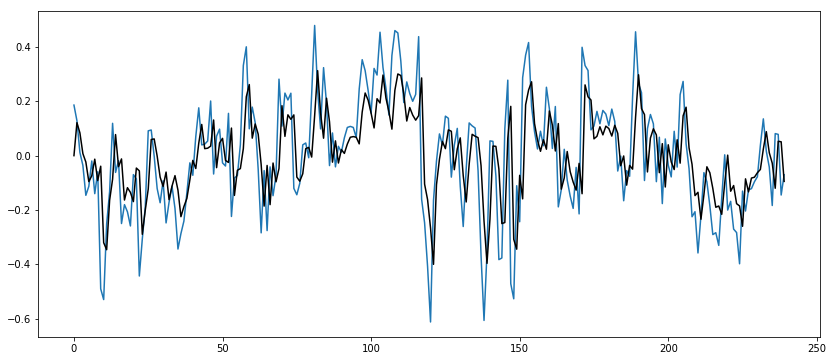

In [663]:
def graficar_precio():
    
        data = load_config()
        p_oni = data["PRECIO"]["P_ONI_OPT"]
        p_aportes = data["PRECIO"]["P_APORTES_OPT"]
        p_embalse = data["PRECIO"]["P_EMBALSE_OPT"]
        p_ghidro = data["PRECIO"]["P_GHIDRO_OPT"]
        p_demanda = data["PRECIO"]["P_DEMANDA_OPT"]
        p_termica = data["PRECIO"]["P_TERMICA_OPT"]  
        p_precio = data['PRECIO']['P_OPT'] 

        x = pd.read_csv("data/data.csv")
        
        ONI = x.ONI[0:240]
        Mes = x.Mes[0:240]
        Aportes = x.Aportes_GWh[0:240]
        
        z = pd.concat([pd.DataFrame(Mes), pd.DataFrame(Aportes)], axis=1)
        z.columns = [z.columns[0], "aportes"]
        means_stds_aportes = z.groupby("Mes").agg({"aportes": [np.mean, np.std]})
        means_stds_aportes.columns = ["mean_mes", "std_mes"]
        Aportes_z = [
            (v - means_stds_aportes["mean_mes"][t])
            / means_stds_aportes["std_mes"][t]
            for v, t in zip(Aportes, Mes)
        ]
        Aportes_z = pd.Series(Aportes_z)
        
        Embalse = x.Volumen_Util_GWh[0:240]
        
        w = pd.concat([pd.DataFrame(Mes), pd.DataFrame(Embalse)], axis=1)
        w.columns = [w.columns[0], "embalse"]
        means_stds_embalse = w.groupby("Mes").agg({"embalse": [np.mean, np.std]})
        means_stds_embalse.columns = ["mean_mes", "std_mes"]
        Embalse_z = [
            (v - means_stds_embalse["mean_mes"][t])
            / means_stds_embalse["std_mes"][t]
            for v, t in zip(Embalse, Mes)
        ]
        Embalse_z = pd.Series(Embalse_z)
        
        
        Ghidro = x.Generacion_Hidro_GWh[0:240]
        Demanda = x.Demanda_GWh[0:240]
        Termica = x.Demanda_GWh[0:240] - x.Generacion_Hidro_GWh[0:240]

        x = x.assign(Factor_IPC=x.IPC / x.IPC[239])
        x = x.assign(Precio_Const=x.Precio_Bolsa * x.Factor_IPC)
        x = x.assign(Log_Precio=x.Precio_Const.map(np.log))
        Precio_log = x.Log_Precio[0:240]
        
        x_oni = lag_time_series(
            serie=ONI, Pmax=p_oni, remove_lag_zero=False
        )
        x_aportes_z = lag_time_series(
            serie=Aportes_z, Pmax=p_aportes, remove_lag_zero=False
        )
        x_embalse_z = lag_time_series(
            serie=Embalse_z, Pmax=p_embalse, remove_lag_zero=False
        )
        x_ghidro = lag_time_series(
            serie=Ghidro, Pmax=p_ghidro, remove_lag_zero=False
        )
        x_demanda = lag_time_series(
            serie=Demanda, Pmax=p_demanda, remove_lag_zero=False
        ) 
        x_termica = lag_time_series(
            serie=Termica, Pmax=p_termica, remove_lag_zero=False
        )        
        x = pd.concat([x_oni, x_aportes_z, x_embalse_z, x_ghidro, x_demanda, x_termica], axis=1)
        y = Precio_log

        #
        # Ajuste y reporte de errores
        # Modelo sin variables explicativas
        #
        m = linear_model.LinearRegression()
        m.fit(x, y)
        predict = m.predict(x)

        #
        # Precio sin variables explicativas
        #
        precio = y - predict

        #
        # Componente autorregresiva
        #

        x = lag_time_series(precio.copy(), Pmax=p_precio, remove_lag_zero=True)
        y = precio.copy()

        m = linear_model.LinearRegression()
        m.fit(x, y)

        y_predict = m.predict(x)
        
        plt.figure(figsize=(14,6))
        plt.plot(y)
        plt.plot(y_predict, c = "k")

x = graficar_precio()
x

## Simulador precio


In [763]:
class PRECIO_simulator:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.Embalse = x.Volumen_Util_GWh[0:240]
        self.Ghidro = x.Generacion_Hidro_GWh[0:240]
        self.Demanda = x.Demanda_GWh[0:240]
        self.Termica = x.Demanda_GWh[0:240] - x.Generacion_Hidro_GWh[0:240]

        data = load_config()
        self.P_ONI = data["PRECIO"]["P_ONI_OPT"]
        self.P_Aportes = data["PRECIO"]["P_APORTES_OPT"]
        self.P_Embalse = data["PRECIO"]["P_EMBALSE_OPT"]
        self.P_Ghidro = data["PRECIO"]["P_GHIDRO_OPT"]
        self.P_Demanda = data["PRECIO"]["P_DEMANDA_OPT"]
        self.P_Termica = data["PRECIO"]["P_TERMICA_OPT"]
        self.P_Precio = data["PRECIO"]["P_OPT"]

    def precio_constantes(self):
        #
        ## Precios corrientes a constantes en la serie del precio de la energía
        #
        x = pd.read_csv("data/data.csv")
        x = x.assign(Factor_IPC=x.IPC / x.IPC[239])
        x = x.assign(Precio_Const=x.Precio_Bolsa * x.Factor_IPC)
        x = x.assign(Log_Precio=x.Precio_Const.map(np.log))
        self.Precio_log = x.Log_Precio[0:240]

    def step_1_remove_Vbles_explicativas(self):
        #
        # Remueve el efecto del ONI, aportes, embalse, ghidro, demanda, termica
        #
        # Regresores

        x_ONI = lag_time_series(serie=self.ONI, Pmax=self.P_ONI, remove_lag_zero=False)
        x_Aportes = lag_time_series(
            serie=self.Aportes, Pmax=self.P_Aportes, remove_lag_zero=False
        )
        x_Embalse = lag_time_series(
            serie=self.Embalse, Pmax=self.P_Embalse, remove_lag_zero=False
        )
        x_Ghidro = lag_time_series(
            serie=self.Ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False
        )
        x_Demanda = lag_time_series(
            serie=self.Demanda, Pmax=self.P_Demanda, remove_lag_zero=False
        )
        x_Termica = lag_time_series(
            serie=self.Termica, Pmax=self.P_Termica, remove_lag_zero=False
        )

        x = pd.concat(
            [x_ONI, x_Aportes, x_Embalse, x_Ghidro, x_Demanda, x_Termica], axis=1
        )

        y = self.Precio_log

        self.modelo_explicativas = linear_model.LinearRegression()
        self.modelo_explicativas.fit(x, y)
        self.Precio_log_sin_explicativas = (
            self.Precio_log - self.modelo_explicativas.predict(x)
        )

    def step_2_fit(self):
        #
        x = lag_time_series(
            serie=self.Precio_log_sin_explicativas,
            Pmax=self.P_Precio,
            remove_lag_zero=True,
        )
        self.modelo_Precio = linear_model.LinearRegression()
        self.modelo_Precio.fit(x, self.Precio_log_sin_explicativas)
        self.errors = (
            self.Precio_log_sin_explicativas - self.modelo_Precio.predict(x)
        )[self.P_Precio + 1 :]
        self.errors = self.errors.tolist()

    def step_3_generate_syntetic_Precio_log_sin_explicativas(self, t_base):
        #
        y = self.Precio_log_sin_explicativas.copy()

        for t in range(t_base, 264):
            y[t] = self.modelo_Precio.intercept_
            for p in range(1, self.P_Precio + 1):
                y[t] += y[t - p] * self.modelo_Precio.coef_[p - 1]
            y[t] += self.errors[np.random.randint(0, len(self.errors))]
        self.syntetic_Precio_log_sin_explicativas = y.copy()

    def step_4_generate_syntetic_Precio_log(
        self,
        sintetica_ONI,
        sintetica_Aportes,
        sintetica_Embalse,
        sintetica_Ghidro,
        sintetica_Demanda_Agente,
        sintetica_Termica,
        t_base,
    ):

        x_ONI = lag_time_series(
            serie=sintetica_ONI, Pmax=self.P_ONI, remove_lag_zero=False
        )

        # Serie sintética de aportes normalizada
        x = pd.DataFrame({"sintetica_Aportes": sintetica_Aportes})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        self.means_stds_aportes = x.groupby("Mes").agg(
            {"sintetica_Aportes": [np.mean, np.std]}
        )
        self.means_stds_aportes.columns = ["mean_mes", "std_mes"]
        self.sintetica_Aportes = x.sintetica_Aportes
        self.Sintetica_Aportes_z = [
            (v - self.means_stds_aportes["mean_mes"][t])
            / self.means_stds_aportes["std_mes"][t]
            for v, t in zip(self.sintetica_Aportes, x.Mes)
        ]
        self.Sintetica_Aportes_z = pd.Series(self.Sintetica_Aportes_z)
        x_Aportes_z = lag_time_series(
            serie=self.Sintetica_Aportes_z, Pmax=self.P_Aportes, remove_lag_zero=False
        )

        # Serie sintética de embalse normalizada
        y = pd.DataFrame({"sintetica_Embalse": sintetica_Embalse})
        y["Mes"] = 0
        mes = 1
        for t in range(len(y.Mes)):
            y.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        self.means_stds_embalse = y.groupby("Mes").agg(
            {"sintetica_Embalse": [np.mean, np.std]}
        )
        self.means_stds_embalse.columns = ["mean_mes", "std_mes"]
        self.sintetica_Embalse = y.sintetica_Embalse
        self.Sintetica_Embalse_z = [
            (v - self.means_stds_embalse["mean_mes"][t])
            / self.means_stds_embalse["std_mes"][t]
            for v, t in zip(self.sintetica_Embalse, y.Mes)
        ]
        self.Sintetica_Embalse_z = pd.Series(self.Sintetica_Embalse_z)

        x_Embalse_z = lag_time_series(
            serie=self.Sintetica_Embalse_z, Pmax=self.P_Embalse, remove_lag_zero=False
        )

        x_Ghidro = lag_time_series(
            serie=sintetica_Ghidro, Pmax=self.P_Ghidro, remove_lag_zero=False
        )

        x_Demanda = lag_time_series(
            serie=sintetica_Demanda_Agente, Pmax=self.P_Demanda, remove_lag_zero=False
        )[0:264]

        x_Termica = lag_time_series(
            serie=sintetica_Termica, Pmax=self.P_Termica, remove_lag_zero=False
        )[0:264]

        x = pd.concat(
            [x_ONI, x_Aportes_z, x_Embalse_z, x_Ghidro, x_Demanda, x_Termica], axis=1
        )
        x.to_csv("temp.csv")
        self.syntetic_Precio_log = (
            self.syntetic_Precio_log_sin_explicativas
            + self.modelo_explicativas.predict(x)
        )

    def step_5_generate_syntetic_Precio(self):

        x = pd.DataFrame({"Precio_log": self.syntetic_Precio_log})
        x["syntetic_Precio"] = x.Precio_log.map(np.exp)
        self.syntetic_Precio = x.syntetic_Precio

    def run(self):

        CONFIG = load_config()

        self.precio_constantes()
        self.step_1_remove_Vbles_explicativas()
        self.step_2_fit()

        for t_base in range(204, 241):

            for escenario_ONI in CONFIG["ONI"]["ESCENARIOS"]:

                filename_ONI = str(t_base) + "/" + "ONI_" + str(escenario_ONI) + ".csv"
                sintetica_ONI = pd.read_csv(filename_ONI)["ONI"]

                for escenario_Demanda in CONFIG["DEMANDA"]["ESCENARIOS"]:

                    filename_Demanda = str(t_base) + "/series-esc-dem-agente.csv"
                    serie_Demanda_Agente = pd.read_csv(filename_Demanda)
                    serie_Demanda_Agente = serie_Demanda_Agente[
                        serie_Demanda_Agente.columns[escenario_Demanda]
                    ]

                    for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):

                        filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(
                            t_base, i_serie, escenario_ONI
                        )
                        sintetica_Aportes = pd.read_csv(filename_aportes)[
                            "sintetic_aportes_sin_oni"
                        ]
                        filename_embalse = "{}/EMBALSE_{:04d}_ONI_{}.csv".format(
                            t_base, i_serie, escenario_ONI
                        )
                        sintetica_Embalse = pd.read_csv(filename_embalse)[
                            "syntetic_embalse"
                        ]
                        filename_ghidro = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(
                            t_base, i_serie, escenario_ONI
                        )
                        sintetica_Ghidro = pd.read_csv(filename_ghidro)[
                            "Generacion_Hidro_GWh"
                        ]
                        sintetica_Termica = serie_Demanda_Agente - sintetica_Ghidro
                        self.step_3_generate_syntetic_Precio_log_sin_explicativas(
                            t_base
                        )
                        self.step_4_generate_syntetic_Precio_log(
                            sintetica_ONI,
                            sintetica_Aportes,
                            sintetica_Embalse,
                            sintetica_Ghidro,
                            serie_Demanda_Agente,
                            sintetica_Termica,
                            t_base,
                        )
                        self.step_5_generate_syntetic_Precio()
                        self.syntetic_Precio.to_csv(
                            "{}/PRECIO_Agente_{:04d}_ONI_{}_dem_{}.csv".format(
                                t_base, i_serie, escenario_ONI, escenario_Demanda
                        ),
                        index=False,
                )
                        
        ##ESCENARIOS OPERADOR
        '''for t_base in range(204, 205):

            escenario_ONI = 50
            escenario_Demanda = 2
            filename_ONI = str(t_base) + "/" + "ONI_" + str(escenario_ONI) + ".csv"
            sintetica_ONI = pd.read_csv(filename_ONI)["ONI"]

            filename_Demanda = str(t_base) + "/series-esc-dem-agente.csv"
            serie_Demanda_Agente = pd.read_csv(filename_Demanda)
            serie_Demanda_Agente = serie_Demanda_Agente[
                serie_Demanda_Agente.columns[escenario_Demanda]
                    ]
            for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):

                filename_aportes = "{}/APORTES_{:04d}_ONI_{}.csv".format(
                    t_base, i_serie, escenario_ONI
                )
                sintetica_Aportes = pd.read_csv(filename_aportes)[
                    "sintetic_aportes_sin_oni"
                ]
                filename_embalse = "{}/EMBALSE_{:04d}_ONI_{}.csv".format(
                    t_base, i_serie, escenario_ONI
                )
                sintetica_Embalse = pd.read_csv(filename_embalse)[
                    "syntetic_embalse"
                ]
                filename_ghidro = "{}/GHIDRO_{:04d}_ONI_{}.csv".format(
                    t_base, i_serie, escenario_ONI
                )
                sintetica_Ghidro = pd.read_csv(filename_ghidro)[
                    "Generacion_Hidro_GWh"
                ]
                sintetica_Termica = serie_Demanda_Agente - sintetica_Ghidro
                self.step_3_generate_syntetic_Precio_log_sin_explicativas(
                    t_base
                )
                self.step_4_generate_syntetic_Precio_log(
                    sintetica_ONI,
                    sintetica_Aportes,
                    sintetica_Embalse,
                    sintetica_Ghidro,
                    serie_Demanda_Agente,
                    sintetica_Termica,
                    t_base,
                )
                self.step_5_generate_syntetic_Precio()
                self.syntetic_Precio.to_csv(
                    "{}/PRECIO_Agente_{:04d}_ONI_{}_dem_{}.csv".format(
                        t_base, i_serie, escenario_ONI, escenario_Demanda
                    ),
                    index=False,
                )'''


x = PRECIO_simulator()
x.precio_constantes()
x.run()

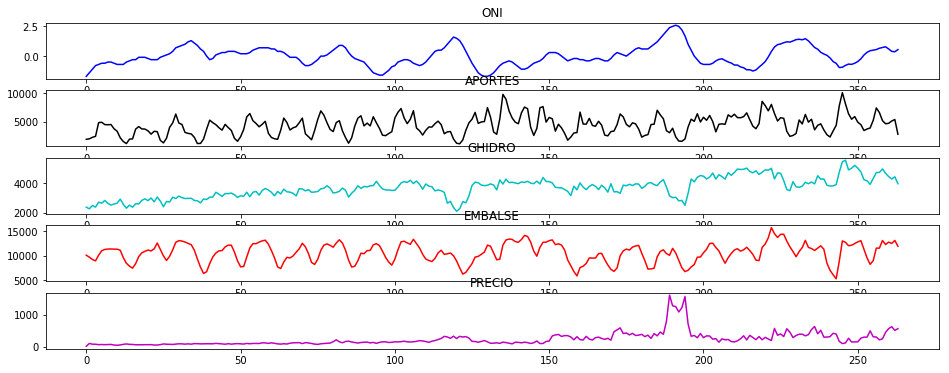

In [765]:
# ONI NIÑA 
prueba_oni = pd.read_csv("204/ONI_11.csv")
prueba_aportes = pd.read_csv("204/APORTES_0099_ONI_11.csv")
prueba_ghidro = pd.read_csv("204/GHIDRO_0099_ONI_11.csv")
prueba_embalse = pd.read_csv("204/EMBALSE_0099_ONI_11.csv")
prueba_precio = pd.read_csv("204/PRECIO_Agente_0099_ONI_11_dem_1.csv")


plt.figure(figsize=(16,6))
plt.subplot(511)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(512)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(513)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.subplot(514)
plt.title("EMBALSE")
plt.plot(prueba_embalse, 'r')
plt.subplot(515)
plt.title("PRECIO")
plt.plot(prueba_precio, 'm')
plt.show()

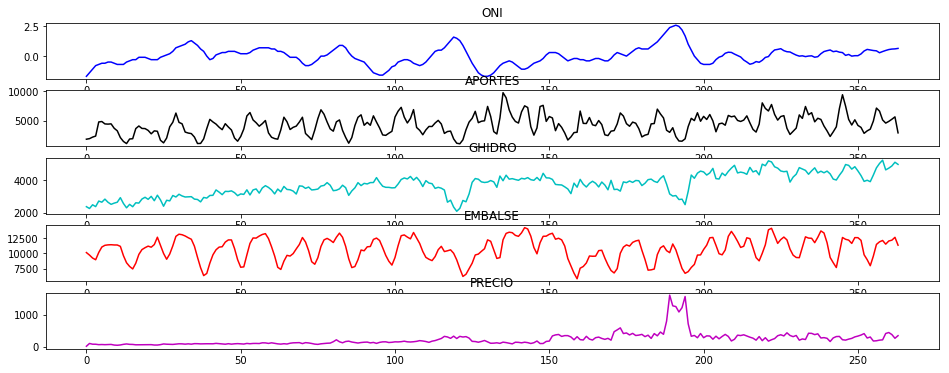

In [766]:
# ONI NORMAL 
prueba_oni = pd.read_csv("204/ONI_49.csv")
prueba_aportes = pd.read_csv("204/APORTES_0099_ONI_49.csv")
prueba_ghidro = pd.read_csv("204/GHIDRO_0099_ONI_49.csv")
prueba_embalse = pd.read_csv("204/EMBALSE_0099_ONI_49.csv")
prueba_precio = pd.read_csv("204/PRECIO_Agente_0099_ONI_49_dem_1.csv")


plt.figure(figsize=(16,6))
plt.subplot(511)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(512)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(513)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.subplot(514)
plt.title("EMBALSE")
plt.plot(prueba_embalse, 'r')
plt.subplot(515)
plt.title("PRECIO")
plt.plot(prueba_precio, 'm')
plt.show()

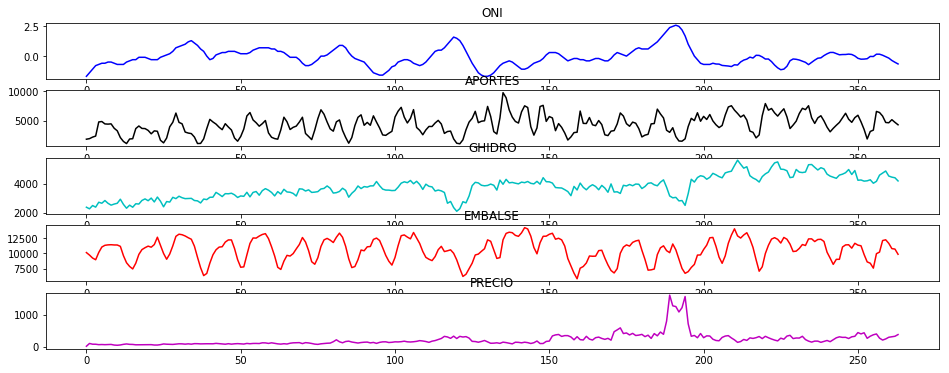

In [307]:
# ONI NIÑO
prueba_oni = pd.read_csv("204/ONI_10.csv")
prueba_aportes = pd.read_csv("204/APORTES_0010_ONI_10.csv")
prueba_ghidro = pd.read_csv("204/GHIDRO_0010_ONI_10.csv")
prueba_embalse = pd.read_csv("204/EMBALSE_0010_ONI_10.csv")
prueba_precio = pd.read_csv("204/PRECIO_Agente_0010_ONI_10_dem_1.csv")


plt.figure(figsize=(16,6))
plt.subplot(511)
plt.title("ONI")
plt.plot(prueba_oni, 'b') 
plt.subplot(512)
plt.title("APORTES")
plt.plot(prueba_aportes, 'k')
plt.subplot(513)
plt.title("GHIDRO")
plt.plot(prueba_ghidro, 'c')
plt.subplot(514)
plt.title("EMBALSE")
plt.plot(prueba_embalse, 'r')
plt.subplot(515)
plt.title("PRECIO")
plt.plot(prueba_precio, 'm')
plt.show()

## Liquidaciones en cada nodo

In [288]:
CONFIG = load_config()

for t_base in range(204, 241):

    nodos_terminales = {}

    for escenario_ONI in CONFIG["ONI"]["ESCENARIOS"]:

        for escenario_Demanda in CONFIG["DEMANDA"]["ESCENARIOS"]:
            filename_compra = "{}/COMPRA_ONI_{}_dem_{}.csv".format(
                t_base, escenario_ONI, escenario_Demanda
            )
            filename_venta = "{}/VENTA_ONI_{}_dem_{}.csv".format(
                t_base, escenario_ONI, escenario_Demanda
            )
            compras = {}
            ventas = {}
            for i_serie in range(CONFIG["APORTES"]["NUMSIM"]):

                filename_precio = "{}/PRECIO_Agente_{:04d}_ONI_{}_dem_{}.csv".format(
                    t_base, i_serie, escenario_ONI, escenario_Demanda
                )

                #derivex_precio = pd.read_csv("Data/Derivex_Promedio.csv")
                derivex_precio = pd.read_csv("Data/Pr_Derivex_Min_Max.csv")

                sim_precio = pd.read_csv(filename_precio)
                
                compra = []
                venta = []

                for i in range(24):

                    compra.append(
                        sim_precio.syntetic_Precio[t_base + i]
                        - derivex_precio.Derivex_Min[t_base - 129 + i]
                    )
                    venta.append(
                        derivex_precio.Derivex_Max[t_base - 129 + i]
                        - sim_precio.syntetic_Precio[t_base + i]
                    )                       
                compras[i_serie] = compra
                ventas[i_serie] = venta
            df1 = pd.DataFrame(compras)
            df1.to_csv(filename_compra, index = False)
            df2 = pd.DataFrame(ventas)
            df2.to_csv(filename_venta, index=False)

## Nodos finales

In [289]:
CONFIG = load_config()

compras = {}
ventas = {}
prob_compras = {}
prob_ventas = {}

for t_base in range(204, 241):
    filename_prob_oni = "{}/prob_ONI.csv".format(t_base)
    filename_prob_dem = "{}/prob_dem.csv".format(t_base)
    prob_oni = pd.read_csv(filename_prob_oni)
    prob_dem = pd.read_csv(filename_prob_dem)
    compra = []
    venta = []
    for escenario_ONI in CONFIG["ONI"]["ESCENARIOS"]:

        for escenario_Demanda in CONFIG["DEMANDA"]["ESCENARIOS"]:
            
            prob_compra = []
            prob_venta = []

            ## Promedio de COMPRAS
            filename_compra = "{}/COMPRA_ONI_{}_dem_{}.csv".format(
                t_base, escenario_ONI, escenario_Demanda
            )
            df_compra = pd.read_csv(filename_compra)
            compras[
                "COMPRA_ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)
            ] = df_compra.mean(axis=1)
            df_compras = pd.DataFrame(compras)

            ## Promedio VENTAS

            filename_venta = "{}/VENTA_ONI_{}_dem_{}.csv".format(
                t_base, escenario_ONI, escenario_Demanda
            )
            df_venta = pd.read_csv(filename_venta)
            ventas[
                "VENTA_ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)
            ] = df_venta.mean(axis=1)
            df_ventas = pd.DataFrame(ventas)
            
            # Suma en los nodos finales DE COMPRA Y VENTA
            for i in range(24):
                
                prob_compra.append(
                    prob_oni[str(escenario_ONI)][i]
                    * prob_dem[str(escenario_Demanda)][i]
                    * df_compras[
                        "COMPRA_ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)
                    ][i]
                )
            
                prob_venta.append(
                    prob_oni[str(escenario_ONI)][i]
                    * prob_dem[str(escenario_Demanda)][i]
                    * df_ventas[
                        "VENTA_ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)
                    ][i]
                )
            prob_compras["ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)] = prob_compra
            prob_ventas["ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)] = prob_venta
            
    df_prob_compras = pd.DataFrame(prob_compras)
    df_prob_compras["Suma"] = df_prob_compras.sum(axis = 1)
    
    df_prob_ventas = pd.DataFrame(prob_ventas)
    df_prob_ventas["Suma"] = df_prob_ventas.sum(axis = 1)
    
    df_prob_compras.to_csv("{}/Nodos_finales_compra_ONI_10_50_90.csv".format(t_base), index = False)
    df_prob_ventas.to_csv("{}/Nodos_finales_venta_ONI_10_50_90.csv".format(t_base), index = False)
                    

## Portafolio

In [296]:
portafolio_compras_ONI_10_50_90 = {t:[(0,0)]   for t in range(204, 240 + 24)}
portafolio_ventas_ONI_10_50_90 = {t:[(0,0)]   for t in range(204, 240 + 24)}
for t_base in range(204,241):
    filename_nodo_compra = "{}/Nodos_finales_compra_ONI_10_50_90.csv".format(t_base)
    df_nodo_compra = pd.read_csv(filename_nodo_compra)
    filename_nodo_venta = "{}/Nodos_finales_venta_ONI_10_50_90.csv".format(t_base)
    df_nodo_venta = pd.read_csv(filename_nodo_venta)
    df_derivex = pd.read_csv("Data/Pr_Derivex_Min_Max.csv")
    for horizonte in range(1, 24):
        #para el mes actual t_base + horizonte decides si compras, vendes o no haces nada
        #agregas el correspondiente contrato al portafolio, un contrato con el precio de derivex
        if(df_nodo_compra.Suma[horizonte] > df_nodo_venta.Suma[horizonte]):
            portafolio_compras_ONI_10_50_90[t_base + horizonte].append((1, df_derivex.Derivex_Min[horizonte + 76]))
            
        else:
            portafolio_ventas_ONI_10_50_90[t_base + horizonte].append((1, df_derivex.Derivex_Max[horizonte + 76]))

## Liquidación total

In [323]:
precio_bolsa = pd.read_csv("data/data.csv").Precio_Bolsa[204:264]
result_compras = []
result_ventas = []

for j in range(204,244):
    liquidacion_compras = 0
    for i in range(len(portafolio_compras_ONI_10_50_90[j])):
        liquidacion_compras += portafolio_compras_ONI_10_50_90[j][i][0] * (
            precio_bolsa[j] - portafolio_compras_ONI_10_50_90[j][i][1]
        )

    result_compras.append(liquidacion_compras)

for j in range(204,244):
    liquidacion_ventas = 0
    for i in range(len(portafolio_ventas_ONI_10_50_90[j])):
        liquidacion_ventas += portafolio_ventas_ONI_10_50_90[j][i][0] * (
            portafolio_ventas_ONI_10_50_90[j][i][1] - precio_bolsa[j]
        )
    result_ventas.append(liquidacion_ventas)


liquidacion_contratos = sum(result_compras + result_ventas)
liquidacion_contratos

55130.521467939994

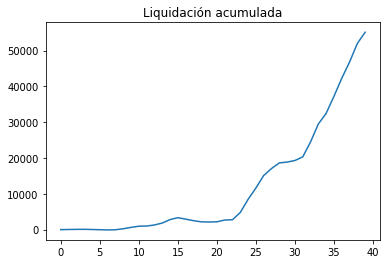

In [327]:
liquidacion_por_mes = [c + v for c,v in zip(result_compras, result_ventas)]
liquidacion_acumulada = np.cumsum(liquidacion_por_mes)
plt.plot(liquidacion_acumulada)
plt.title("Liquidación acumulada")
plt.show()

In [261]:
portafolio_compras_ONI_10_50_90

{204: [(0, 0)],
 205: [(0, 0), (1, 195.1304542121296)],
 206: [(0, 0), (1, 186.2797845729644), (1, 195.1304542121296)],
 207: [(0, 0),
  (1, 179.2207360615343),
  (1, 186.2797845729644),
  (1, 195.1304542121296)],
 208: [(0, 0),
  (1, 173.48441170476696),
  (1, 179.2207360615343),
  (1, 195.1304542121296)],
 209: [(0, 0),
  (1, 169.6993303777119),
  (1, 173.48441170476696),
  (1, 186.2797845729644),
  (1, 195.1304542121296)],
 210: [(0, 0),
  (1, 170.33085000590705),
  (1, 169.6993303777119),
  (1, 179.2207360615343),
  (1, 186.2797845729644),
  (1, 195.1304542121296)],
 211: [(0, 0),
  (1, 173.45445088099038),
  (1, 170.33085000590705),
  (1, 169.6993303777119),
  (1, 173.48441170476696),
  (1, 179.2207360615343),
  (1, 186.2797845729644),
  (1, 195.1304542121296)],
 212: [(0, 0),
  (1, 173.4116417516856),
  (1, 173.45445088099038),
  (1, 170.33085000590705),
  (1, 169.6993303777119),
  (1, 173.48441170476696),
  (1, 179.2207360615343),
  (1, 186.2797845729644),
  (1, 195.130454212129

In [527]:
prob_compras = {}
for t_base in range(204, 205):
    for escenario_ONI in CONFIG["ONI"]["ESCENARIOS"]:
        for escenario_Demanda in CONFIG["DEMANDA"]["ESCENARIOS"]:
            prob_compra = []
            for i in range(24):

                filename_prob_oni = "{}/prob_ONI.csv".format(t_base)
                filename_prob_dem = "{}/prob_dem.csv".format(t_base)
                prob_oni = pd.read_csv(filename_prob_oni)
                prob_dem = pd.read_csv(filename_prob_dem)
                # print(prob_oni[str(escenario_ONI)][escenario_Demanda])
                # print(prob_dem[str(escenario_Demanda)][escenario_Demanda])
                prob_compra.append(
                    prob_oni[str(escenario_ONI)][escenario_Demanda]
                    * prob_dem[str(escenario_Demanda)][escenario_Demanda]
                    * df_compras[
                        "COMPRA_ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)
                    ][i]
                )
            prob_compras["ONI_{}_dem_{}".format(escenario_ONI, escenario_Demanda)] = prob_compra
    df_prob_compras1 = pd.DataFrame(prob_compras)
    df_prob_compras1["Suma"] = df_prob_compras1.sum(axis = 1)
    df_prob_compras.to_csv("{}/Nodos_finales_compra.csv".format(t_base), index = False)

In [254]:
%%writefile 240/prob_oni.csv
"10","50","90"
0.43,0.57,0.00
0.28,0.70,0.20
0.19,0.74,0.07
0.14,0.74,0.12
0.12,0.67,0.21
0.12,0.60,0.28
0.13,0.54,0.33
0.15,0.50,0.35
0.15,0.49,0.36
0.70,0.20,0.10
0.80,0.10,0.10
0.90,0.10,0.00
0.97,0.03,0.00
0.85,0.15,0.00
0.63,0.36,0.01
0.46,0.50,0.04
0.34,0.58,0.08
0.26,0.58,0.16
0.25,0.53,0.22
0.22,0.52,0.26
0.23,0.49,0.28
0.10,0.32,0.58
0.07,0.33,0.60
0.05,0.30,0.65

Overwriting 240/prob_oni.csv


In [513]:
portafolio_compras = {t:[]   for t in range(204, 240 + 24)}
portafolio_compras[206].append((1,205.35))
#portafolio_compras

In [ ]:
for t_base in range(204,241):
    #se carga el valor del nodo de compra el t_base actual
    #se carga el valor del nodo de venta del t_base actual
    for horizonte in range(24):
        #para el mes actual t_base + horizonte decides si compras, vendes o no haces nada
        #agregas el correspondiente contrato al portafolio, un contrato con el precio de derivex
        


In [629]:
precio_min = pd.read_csv("Data/Pr_Derivex_Min_Max.csv")
precio_min.Derivex_Max[75:100]

75    236.81
76    236.81
77    241.28
78    220.00
79    220.00
80    200.00
81    204.05
82    204.05
83    204.05
84    193.66
85    195.06
86    210.99
87    222.40
88    222.40
89    222.40
90    234.60
91    221.00
92    209.50
93    200.50
94    197.00
95    198.00
96    198.20
97    198.20
98    197.00
99    321.57
Name: Derivex_Max, dtype: float64

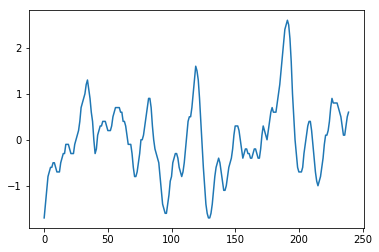

In [272]:
datos = pd.read_csv("data/data1.csv")
plt.plot(datos.ONI)

In [265]:
datos.columns

Index(['Ano', 'Mes', 'Fecha', 'Precio_Bolsa', 'Aportes_GWh',
       'Volumen_Util_GWh', 'Demanda_GWh', 'ONI', 'CEN_Total', 'CEN_Hidro',
       'CEN_Termica', 'Generacion_Hidro_GWh', 'Generacion_Otros_GWh', 'IPC',
       'PRJ_0', 'PRJ_1', 'PRJ_2', 'PRJ_3', 'PRJ_4', 'PRJ_5', 'PRJ_6'],
      dtype='object')